# Simple CNN for PETALO

Esta red la vamos a utilizar para obtener el radio 

Comentarios:

Intenté escalar ty fue un verdadero fracaso, así que no utilizar

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys

sys.path.append("/home/rgadea/lmfit-py/")
sys.path.append("/home/rgadea/experimentos/viherbos/")

print(sys.path)
import json 

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D,Conv3D, MaxPooling3D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['/home/rgadea/anaconda3/envs/tensorflow3/lib/python36.zip', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/lib-dynload', '', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages', '/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/IPython/extensions', '/volumedisk0/home/rgadea/.ipython', '/home/rgadea/lmfit-py/', '/home/rgadea/experimentos/viherbos/']


Using TensorFlow backend.
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rgadea/anaconda3/envs/tensorflow3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
import tensorflow as tf
print(tf.__version__)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

1.13.1


## Vamos introducir los datos de petalo preprocesados en pyhton


In [3]:
filtro=2
if filtro==1:
    npzfile = np.load('../conjuntos_datos_nuevos_2020/20_12_2019_comptom_filt.npz')
    npzfile.files
    conjunto_datos_entradasA=npzfile['arr_0']
    conjunto_datos_entradasB=npzfile['arr_1']
    conjunto_datos_salidas=npzfile['arr_2']
else:
    if filtro==2:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/29_12_2019_comptom_filt4.npz')
        npzfile.files
        conjunto_datos_entradasA=npzfile['arr_0']
        conjunto_datos_entradasB=npzfile['arr_1']
        conjunto_datos_salidas=npzfile['arr_2']
    else:
        npzfile = np.load('../conjuntos_datos_nuevos_2020/11_12_2019.npz')
        npzfile.files
        entradas_sensorsA1=npzfile['arr_0']
        entradas_sensorsB1=npzfile['arr_1']
        coordenadas1=npzfile['arr_2']
        entradas_sensorsA2=npzfile['arr_3']
        entradas_sensorsB2=npzfile['arr_4']
        coordenadas2=npzfile['arr_5']
        conjunto_datos_entradasA=np.concatenate((entradas_sensorsA1,entradas_sensorsA2),axis=0)
        conjunto_datos_entradasB=np.concatenate((entradas_sensorsB1,entradas_sensorsB2),axis=0)
        conjunto_datos_salidas=np.concatenate((coordenadas1,coordenadas2),axis=0)


print('conjunto_datos_entradas A shape:', conjunto_datos_entradasA.shape)
print('conjunto_datos_entradas B shape:', conjunto_datos_entradasB.shape)
print('conjunto_datos_salidas shape:', conjunto_datos_salidas.shape)

conjunto_datos_entradas A shape: (39012, 20, 175)
conjunto_datos_entradas B shape: (39012, 20, 175)
conjunto_datos_salidas shape: (39012, 3)


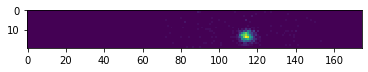

[179.48995755 232.36752293  28.5995636 ]


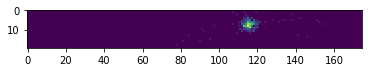

[179.04059897 235.0181863  -14.96378708]


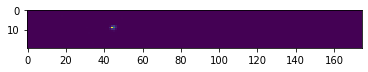

[191.78897104  87.78691228  -3.52812505]


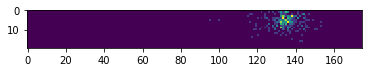

[166.73997562 273.6496088  -28.85614204]


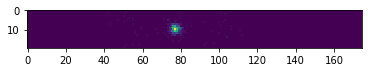

[181.79951424 155.86824087   1.53249276]


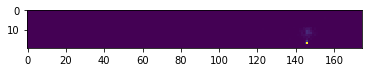

[179.97673628 298.39953708  14.31007481]


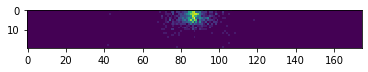

[165.82072958 175.23075543 -47.84857941]


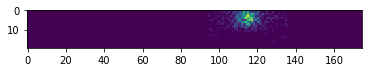

[167.86591545 234.0620098  -39.39222336]


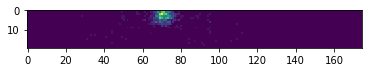

[174.36473219 143.47169795 -48.28456116]


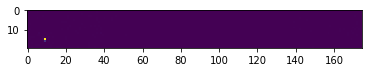

[193.87985536  15.81019628  41.63842773]


In [4]:
for i in range(1,11):
    idea=np.random.randint(1,conjunto_datos_entradasB.shape[0])
    plt.imshow(conjunto_datos_entradasB[idea], cmap='viridis')
    plt.show()
    print(conjunto_datos_salidas[idea,0:3])

## Network parameters:

In [5]:

batch_size = 250
nb_classes = 10
nb_epoch = 2000

# input image dimensions
img_rows, img_cols = 20, 41
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (1,2, 2)
# convolution kernel size
kernel_size = (2, 4, 4)

## Prepare data into training and test set.

In [6]:
muestras=conjunto_datos_entradasA.shape[0]
# veamos=idea.reshape(idea.shape[0],175, 20)


veamos2A=np.zeros([muestras,20,175])
veamos2_3A=np.zeros([muestras,20,525])
veamos2B=np.zeros([muestras,20,175])
veamos2_3B=np.zeros([muestras,20,525])
sector2A=np.zeros([muestras,20,img_cols])
sector2B=np.zeros([muestras,20,img_cols])
veamos3=np.zeros([muestras,175])
# for i in range(idea.shape[0]):
for i in range(muestras):
    veamos2A[i]=conjunto_datos_entradasA[i]
    veamos2B[i]=conjunto_datos_entradasB[i]
    veamos3[i]=np.sum(veamos2A[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    indice_inferior=int(indice-((img_cols-1)/2)+175)
    indice_superior=int(indice+((img_cols+1)/2)+175)
    veamos2_3A[i]=np.concatenate((veamos2A[i],veamos2A[i],veamos2A[i]),axis=1) 
    veamos2_3B[i]=np.concatenate((veamos2B[i],veamos2B[i],veamos2B[i]),axis=1) 
    sector2A[i]=veamos2_3A[i,:,indice_inferior:indice_superior]
    sector2B[i]=veamos2_3B[i,:,indice_inferior:indice_superior]      

## data augmentation mediante flip horizontal y vertical

Atencion: la z es copiada pero en realidad es incorrecta. Podemos asegurar que el radio y phi si que son las mismas; pero la z claramente al hacer un flip vertical no puede ser la misma

In [7]:
veamosA=np.zeros([3*muestras,20,img_cols])
veamosB=np.zeros([3*muestras,20,img_cols])
conjunto_datos_salidas_nuevo=np.zeros([3*muestras,3])
for i in range(muestras):
    veamosA[i*3]=sector2A[i]   
    veamosA[i*3+1]=np.flipud(sector2A[i])   
    veamosA[i*3+2]=np.fliplr(sector2A[i])     
    veamosB[i*3]=sector2B[i]   
    veamosB[i*3+1]=np.flipud(sector2B[i])   
    veamosB[i*3+2]=np.fliplr(sector2B[i])   
    conjunto_datos_salidas_nuevo[i*3]=conjunto_datos_salidas[i]
    conjunto_datos_salidas_nuevo[i*3+1]=conjunto_datos_salidas[i]    
    conjunto_datos_salidas_nuevo[i*3+2]=conjunto_datos_salidas[i]    

In [8]:
print('sector A shape:', veamosA.shape)
conjunto_datos_nuevoA=veamosA.reshape(veamosA.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo A:', conjunto_datos_nuevoA.shape)

print('sector B shape:', veamosB.shape)
conjunto_datos_nuevoB=veamosB.reshape(veamosB.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo B:', conjunto_datos_nuevoB.shape)
print('conjunto_datos_salidas_nuevo:', conjunto_datos_salidas_nuevo.shape)

sector A shape: (117036, 20, 41)
conjunto_datos_nuevo A: (117036, 820)
sector B shape: (117036, 20, 41)
conjunto_datos_nuevo B: (117036, 820)
conjunto_datos_salidas_nuevo: (117036, 3)


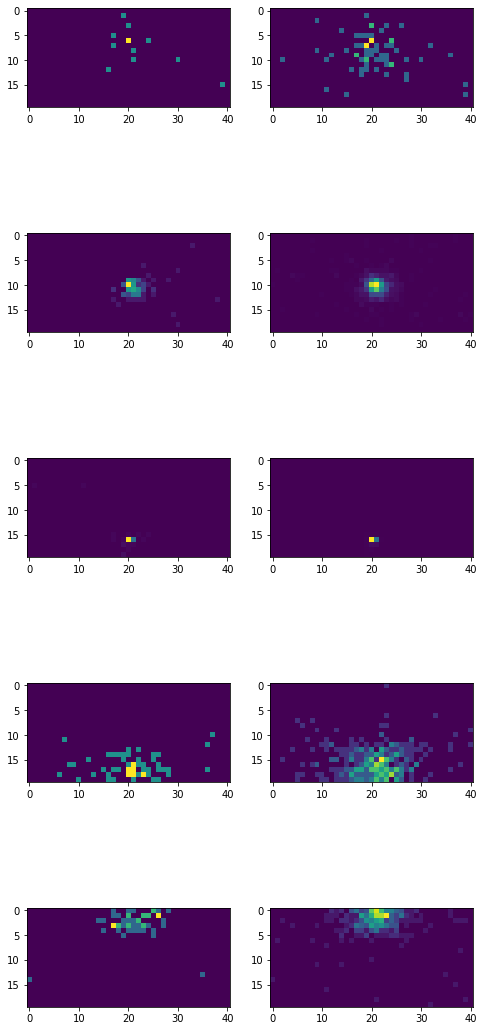

In [9]:
n = 5  # how many digits we will display

fig = plt.figure(figsize=(8,20))

for i in range(n):
    # display original
    ideas=np.random.randint(1,muestras)
    ax = fig.add_subplot(n, 2, (i)*2+1)
    plt.imshow(sector2A[ideas], cmap='viridis')
    plt.viridis()

    # display reconstruction
    ax = fig.add_subplot(n, 2, (i)*2+2)
    plt.imshow(sector2B[ideas], cmap='viridis')
    plt.viridis()

plt.show()

# print(x_test[idea])
# print(decoded_imgs[idea])
# print(decoded_imgs_scaled[idea])


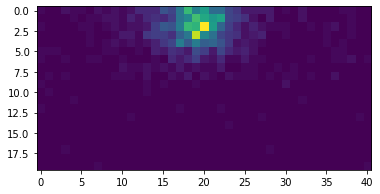

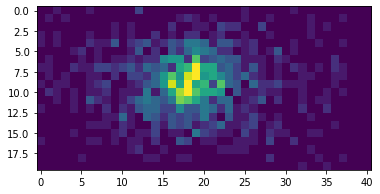

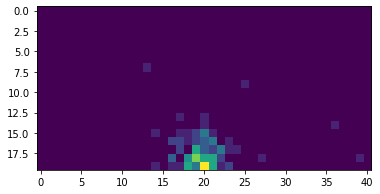

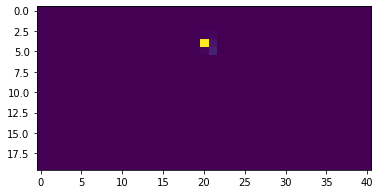

In [10]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2B.shape[0])
    plt.imshow(sector2B[idea], cmap='viridis')
    plt.show()

In [11]:
numero_muestras=3*muestras
tr_size=60
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos_salidas_nuevo,conjunto_datos_nuevoB, conjunto_datos_nuevoA), axis=1)

tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,0]>=164.9999) * (XY_test[:,0]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,0]>=171.000) * (XY_test[:,0]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,0]>=177.000) * (XY_test[:,0]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,0]>=183.000) * (XY_test[:,0]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,0]>=189.0000))]

X_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
X_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
X_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]









X_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,0]
print(X_test_bin0.shape)
X_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,0]
print(X_test_bin1.shape)
X_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,0]
print(X_test_bin2.shape)
X_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,0]
print(X_test_bin3.shape)
X_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,0]
print(X_test_bin4.shape)

Y_train=conjunto_datos_nuevo2[:tamanyo_tr,0] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,0] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,0] #elijo la corrdenada radius

70221
23407
23408
(8211, 1640)
(4509, 1640)
(3807, 1640)
(3236, 1640)
(3645, 1640)


Vamos a normalizar las salidas por si luego nos interea

In [12]:
Y_total=conjunto_datos_nuevo2[:numero_muestras,0]
min_max_scaler = preprocessing.MinMaxScaler().fit(Y_total.reshape(-1, 1))

X_total=conjunto_datos_nuevo2[:numero_muestras,3:]
min_max_scalerx = preprocessing.MinMaxScaler().fit(X_total)

X_train = min_max_scalerx.transform(X_train)
X_val = min_max_scalerx.transform(X_val)
X_test = min_max_scalerx.transform(X_test)

Y_train_scaled = min_max_scaler.transform(Y_train.reshape(-1, 1))
Y_val_scaled = min_max_scaler.transform(Y_val.reshape(-1, 1))
Y_test_scaled = min_max_scaler.transform(Y_test.reshape(-1, 1))

Y_test_bin4_scaled=min_max_scaler.transform(Y_test_bin4.reshape(-1, 1))
Y_test_bin3_scaled=min_max_scaler.transform(Y_test_bin3.reshape(-1, 1))
Y_test_bin2_scaled=min_max_scaler.transform(Y_test_bin2.reshape(-1, 1))
Y_test_bin1_scaled=min_max_scaler.transform(Y_test_bin1.reshape(-1, 1))
Y_test_bin0_scaled=min_max_scaler.transform(Y_test_bin0.reshape(-1, 1))

In [13]:


X_train = X_train.reshape(X_train.shape[0],2, img_rows, img_cols,1)
X_val = X_val.reshape(X_val.shape[0], 2, img_rows, img_cols,1)
X_test = X_test.reshape(X_test.shape[0], 2,img_rows, img_cols,1)

X_test_bin0 = X_test_bin0.reshape(X_test_bin0.shape[0], 2, img_rows, img_cols,1)
X_test_bin1 = X_test_bin1.reshape(X_test_bin1.shape[0], 2, img_rows, img_cols,1)
X_test_bin2 = X_test_bin2.reshape(X_test_bin2.shape[0], 2, img_rows, img_cols,1)
X_test_bin3 = X_test_bin3.reshape(X_test_bin3.shape[0], 2, img_rows, img_cols,1)
X_test_bin4 = X_test_bin4.reshape(X_test_bin4.shape[0], 2, img_rows, img_cols,1)

input_shape = (2, img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [14]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (70221, 2, 20, 41, 1)
70221 train samples
23407 validation samples
23408 test samples


## Data augmentation

In [15]:
datagen = ImageDataGenerator(horizontal_flip=True,
                            vertical_flip=True)

## Build the CNN. 

In [16]:
model = Sequential()

model.add(Conv3D(16, kernel_size=kernel_size,
                        padding='same',
                        data_format='channels_last',
                        input_shape=(2,img_rows,img_cols,1)))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(16, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))
model.add(MaxPooling3D(pool_size=pool_size))

model.add(Conv3D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Conv3D(32, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Conv3D(64, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Conv3D(128, kernel_size, padding='same'))
model.add(BatchNormalization())
model.add(Activation('tanh'))

model.add(Dropout(0.2))
model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation('tanh'))
model.add(Dense(1))
model.add(Activation('tanh'))

dt = datetime.now().replace(second=0, microsecond=0)
experimento="CNN_kernel_{}x{}x{}_con_batchnormalization_sector_{}x{}x{}_elu".format(kernel_size[0],kernel_size[1],kernel_size[2],img_rows,img_cols,1)
algoritmo='RMSprop'
optimizador=Nadam(beta_1=0.9, beta_2=0.999)

tensorboard=TensorBoard(log_dir="../logs/defs/{}{}{}".format(experimento,algoritmo,dt))
best_model_name='../redes_CNN_R/models_best/CNN_regression_R_{}_{}_{}_{}_{}.h5'.format(nb_epoch,batch_size,experimento,algoritmo,dt)
model_check=ModelCheckpoint(best_model_name, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=600, verbose=1, mode='auto', baseline=None)
model.compile(loss='mean_squared_error',
              optimizer=optimizador)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Show a summary of the model parameters. 

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 2, 20, 41, 16)     528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 20, 41, 16)     64        
_________________________________________________________________
activation_1 (Activation)    (None, 2, 20, 41, 16)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 10, 20, 16)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 10, 20, 16)     8208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 10, 20, 16)     64        
_________________________________________________________________
activation_2 (Activation)    (None, 2, 10, 20, 16)     0         
__________

And now train the model and evaluate on the test set. 

In [18]:
history = model.fit(X_train, Y_train_scaled, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(X_val, Y_val_scaled),
                     callbacks=[tensorboard,model_check,early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 70221 samples, validate on 23407 samples
Epoch 1/2000
70221/70221 [==============================] - 13s 181us/step - loss: 0.4510 - val_loss: 0.4455

Epoch 00001: val_loss improved from inf to 0.44554, saving model to ../redes_CNN_R/models_best/CNN_regression_R_2000_250_CNN_kernel_2x4x4_con_batchnormalization_sector_20x41x1_elu_RMSprop_2019-12-24 12:22:00.h5
Epoch 2/2000
70221/70221 [==============================] - 10s 146us/step - loss: 0.4508 - val_loss: 0.4455

Epoch 00002: val_loss did not improve from 0.44554
Epoch 3/2000
70221/70221 [==============================] - 10s 146us/step - loss: 0.4508 - val_loss: 0.4455

Epoch 00003: val_loss did not improve from 0.44554
Epoch 4/2000
70221/70221 [==============================] - 10s 146us/step - loss: 0.4508 - val_loss: 0.4455

Epoch 00004: val_loss did not improve from 0.44554
Epoch 5/2000
70221/70221 [==============================] - 10s 146us/step - loss: 0.4508 - val_lo

KeyboardInterrupt: 

In [ ]:
dt = datetime.now().replace(second=0, microsecond=0)
model.save_weights('../redes_CNN_R/defs/CNN_regression_R_{}_{}_{}_{}_{}'.format(nb_epoch,batch_size,experimento,algoritmo,dt))

In [ ]:
best_model = load_model(best_model_name)
score = best_model.evaluate(X_test, Y_test_scaled, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted_scaled=model.predict(X_test)
print(Y_test_predicted_scaled[:10].flatten())
print(Y_test_scaled[:10])
Y_test_predicted = min_max_scaler.inverse_transform(Y_test_predicted_scaled)
error_prediction=Y_test-Y_test_predicted.flatten()

print(error_prediction[:10])

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#print(error_prediction)

In [ ]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [ ]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [ ]:
print(FWHM)

In [ ]:
Y_test_bin0_predicted_scaled=model.predict(X_test_bin0)
print(Y_test_bin0_predicted_scaled)
Y_test_bin0_predicted = min_max_scaler.inverse_transform(Y_test_bin0_predicted_scaled)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

In [ ]:
Y_test_bin1_predicted_scaled=model.predict(X_test_bin1)
#print(Y_test_bin1_predicted)
Y_test_bin1_predicted = min_max_scaler.inverse_transform(Y_test_bin1_predicted_scaled)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

In [ ]:
Y_test_bin2_predicted_scaled=model.predict(X_test_bin2)
#print(Y_test_bin2_predicted)
Y_test_bin2_predicted = min_max_scaler.inverse_transform(Y_test_bin2_predicted_scaled)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

In [ ]:
Y_test_bin3_predicted_scaled=model.predict(X_test_bin3)
#print(Y_test_bin3_predicted)
Y_test_bin3_predicted = min_max_scaler.inverse_transform(Y_test_bin3_predicted_scaled)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

In [ ]:
Y_test_bin4_predicted_scaled=model.predict(X_test_bin4)
#print(Y_test_bin4_predicted)
Y_test_bin4_predicted = min_max_scaler.inverse_transform(Y_test_bin4_predicted_scaled)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)

Veamos ahora los histogramnas 2d que nos interesan